<a href="https://colab.research.google.com/github/NihilisticMotif/CheCheConjecture/blob/main/ML_Stats/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting Data

##[Step 1]: Import library and data set

In [ ]:
!pip install --upgrade -q gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
# import

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from IPython.display import clear_output
from six.moves import urllib

from IPython.display import display, Latex

# Connect Google Collab with Google Sheet

from google.colab import auth
import gspread
from google.auth import default
from google.colab import data_table

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('student-mat').get_worksheet(0)
rows = worksheet.get_all_values()
dfmain = pd.DataFrame(rows)

# Display Data form Google Sheet

dfmain.head()

##[Step 2]: clean data set

In [ ]:
# [1.] Get string from the first row of every columns
# reference: https://www.easytweaks.com/get-first-row-pandas-dataframe/
ColumnName = dfmain.iloc[0].to_list()

# [2.] Rename every column
for i in range(len(ColumnName)):
  dfmain.rename(columns={i:ColumnName[i]},inplace=True)

# [3.] Drop first row
dfmain=dfmain.drop([0], axis=0)

# [4.] Change Data Type
# reference: https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/
# reference: https://statisticsglobe.com/convert-string-boolean-pandas-dataframe-column-python
# reference: https://sparkbyexamples.com/pandas/pandas-convert-column-to-numpy-array/
# reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
# reference: https://stackoverflow.com/questions/2468334/creating-dynamic-and-expandable-dictionaries-in-python
# reference: https://favtutor.com/blogs/merge-dictionaries-python
# reference: https://datagy.io/python-int-to-binary/

# Change the data type of every column in dfmain
for i in range(len(ColumnName)):
  IsD=np.array(dfmain[ColumnName[i]])[0]
  if IsD.isdigit():
    # Change data type from String into Integer
    dfmain[ColumnName[i]]=dfmain[ColumnName[i]].apply(pd.to_numeric)
  else:
    continue
    dfmain[ColumnName[i]] = dfmain[ColumnName[i]].map(dict(Convert['data'][-1]))

In [ ]:
# [5.] Select only columns with numetric data type because in most case, linear regression is not work well with boolean data type
# and we want to demonstrate how linear regression with multiple features works.
# reference: https://stackoverflow.com/questions/33957720/how-to-convert-column-with-dtype-as-object-to-string-in-pandas-dataframe

ColumnType=dfmain.dtypes.astype('|S8')
ColumnInt=[]
ColumnNot=[]

for i in range(len(ColumnName)):
  if str(ColumnType[i])=="b'int64'":
    ColumnInt.append(ColumnName[i])
  else:
    ColumnNot.append(ColumnName[i])

# [6.A] Select only 2 column, which are the single-feature input column and the out put column, in order to demonstrate
# 1 feature
ColAll=ColumnInt
ColX1f=[ColumnInt[-2]]
ColY1f=[ColumnInt[-1]]
df1f=dfmain.loc[:, dfmain.columns.intersection([ColX1f[0],ColY1f[0]])]

# [6.A] Select every only columns with numetric data.
# multiple features
dfmf=dfmain.drop(columns=ColumnNot)

ColXmf=[]

ColXmf=[]
for i in range(len(ColAll)):
  if ColAll[i] not in ColY1f:
    ColXmf.append(ColAll[i])

##[Step 3]: separate training data set from evaluating data set

In [ ]:
Col_Y=ColY1f
print('The Y column is',Col_Y)

In [ ]:
# Separate training and evaluating data in order to evaluate how well the algorithm predict data out side its data set.

def SeparateData(data,Ratio,nameY):

  DataRatio = int(data.shape[0]*Ratio)
  Data=data.sample(frac = 1)
  TrainD= Data.iloc[:DataRatio]
  TesttD= Data.iloc[DataRatio:]

  TrainX=TrainD.drop(nameY, axis=1)
  TrainY=TrainD[nameY]
  TesttX=TesttD.drop(nameY, axis=1)
  TesttY=TesttD[nameY]

  return [TrainX,TrainY,TesttX,TesttY]

df=dfmf
DaDmf=SeparateData(dfmf,0.75,ColY1f)
TrX=DaDmf[0]
TrY=DaDmf[1]
TeX=DaDmf[2]
TeY=DaDmf[3]

#Introduction of Linear Regression

##Introduction

**What is Linear Regression**

In statistics, linear regression is a linear approach for modelling the relationship between multiple variables. This tutorial demonstrate the simplest linear regression model.

Here is the source of this dataset: https://youtu.be/BOhgGA7Eu5E

**What I will do in this tutorial?**
* I will demonstrate how to implement Linear Regression.

1. Implementing Linear Regression
  1. Initializing Variable (Hypothesis function)
  2. Creating Evaluating Function (Loss Function, Square Error function)
  3. Creating Optimizing Evaluating Function (Gradient Descent function)
  4. Implement Linear Regression using SK learn library.
  4. Evaluate the accuracy of both models (R square)
4. Plotting Graph of both models.
 1. Ploting the accual and predicted value
 2. Ploting bias (x), weight (y) and the Loss function (z)
 3. Ploting the epochs and Loss function (y)

##Creating Hypothesis Function and define variables

Linear regression is a machine learning model which is used for predicting the relationship between matrix $X$ and vector $\vec{y}$, based on the given data on the graph.In this case, the linear regression is displayed as

* $\vec{y}'=h(X)=X\cdot\vec{w}+\vec{b}$
 * $m=$ number of all rows
 * $n=$ number of all features
 * $X\in\mathbb{R^{m\times n}}=$ input matrix
 * $\vec{y}'\in\mathbb{R^{n}}=$ output
 * $\vec{w}\in\mathbb{R^{n}}=$ weight
 * $\vec{b}\in\mathbb{R^{m}}=$ bias

##Creating Evaluating Function (a.k.a. Loss Function or Means Square Error)

**Accuracy of hypothesis function**

The Loss function is a method of evaluating how well the hypothesis function is modeling the dataset. The lower the loss function, the better the model. (https://www.analyticsvidhya.com/blog/2022/06/understanding-loss-function-in-deep-learning/)

$J(\vec{w},b)=\frac{1}{2m}\sum_{i=1}^m(y'_i-y_i)^2$

* error = $y'_i - y_i$
* $m$ = number of all training example.

Q: Why $\frac{1}{2m}$ ?

Q: Why do we have to divide by 2 in the ML squared error cost function?

A: It is because when you take the derivative of the cost function, that is used in updating the parameters during gradient descent, that 2 in the power get canceled with the 1/2 multiplier, thus the derivation is cleaner. (https://datascience.stackexchange.com/questions/52157/why-do-we-have-to-divide-by-2-in-the-ml-squared-error-cost-function)


Q: Why $(...)^2$  ?

Q: Why is a square mean error used instead of taking its absolute value? Both are removed negatives, but why is the mean squared error so widely used?

A: By squaring the errors we are ignoring the effect of sign $(+ -)$.
The contribution of larger errors to the sum of errors becomes more compared to small errors.
(https://www.quora.com/Why-is-a-square-mean-error-used-instead-of-taking-its-absolute-value-Both-are-removed-negatives-but-why-is-the-mean-squared-error-so-widely-used)


##Create Optimization Function using Gradient Descent

**Gradient descent of linear regression**

Gradient descent is an optimization algorithm which is used for minimizing error value of the error function

$\vec{w}_n:=\vec{w}_n-a*\frac{\partial}{\partial \vec{w}_n}J(\vec{w}_n)$
* $\frac{\partial}{\partial \vec{w}_n}J(\vec{w}_n)=\frac{1}{m}[(X_{m\times n}\cdot\vec{w}_n+b\cdot\vec{1}_{m}-\vec{y}_m)\cdot X_{m\times n}]$

$b:=b-a*\frac{\partial}{\partial b}J(b)$
* $\frac{\partial}{\partial b}J(b)=\frac{1}{m}[(X_{m\times n}\cdot\vec{w}_n+b\cdot\vec{1}_{m}-\vec{y}_m)\cdot \vec{1}_{m}]$

**Note**
* $J,a,b,\frac{\partial}{\partial b}J(b)\in\mathbb{R}$
* $\vec{w}_n,\frac{\partial}{\partial \vec{w}_n}J(\vec{w}_n)\in\mathbb{R^n}$

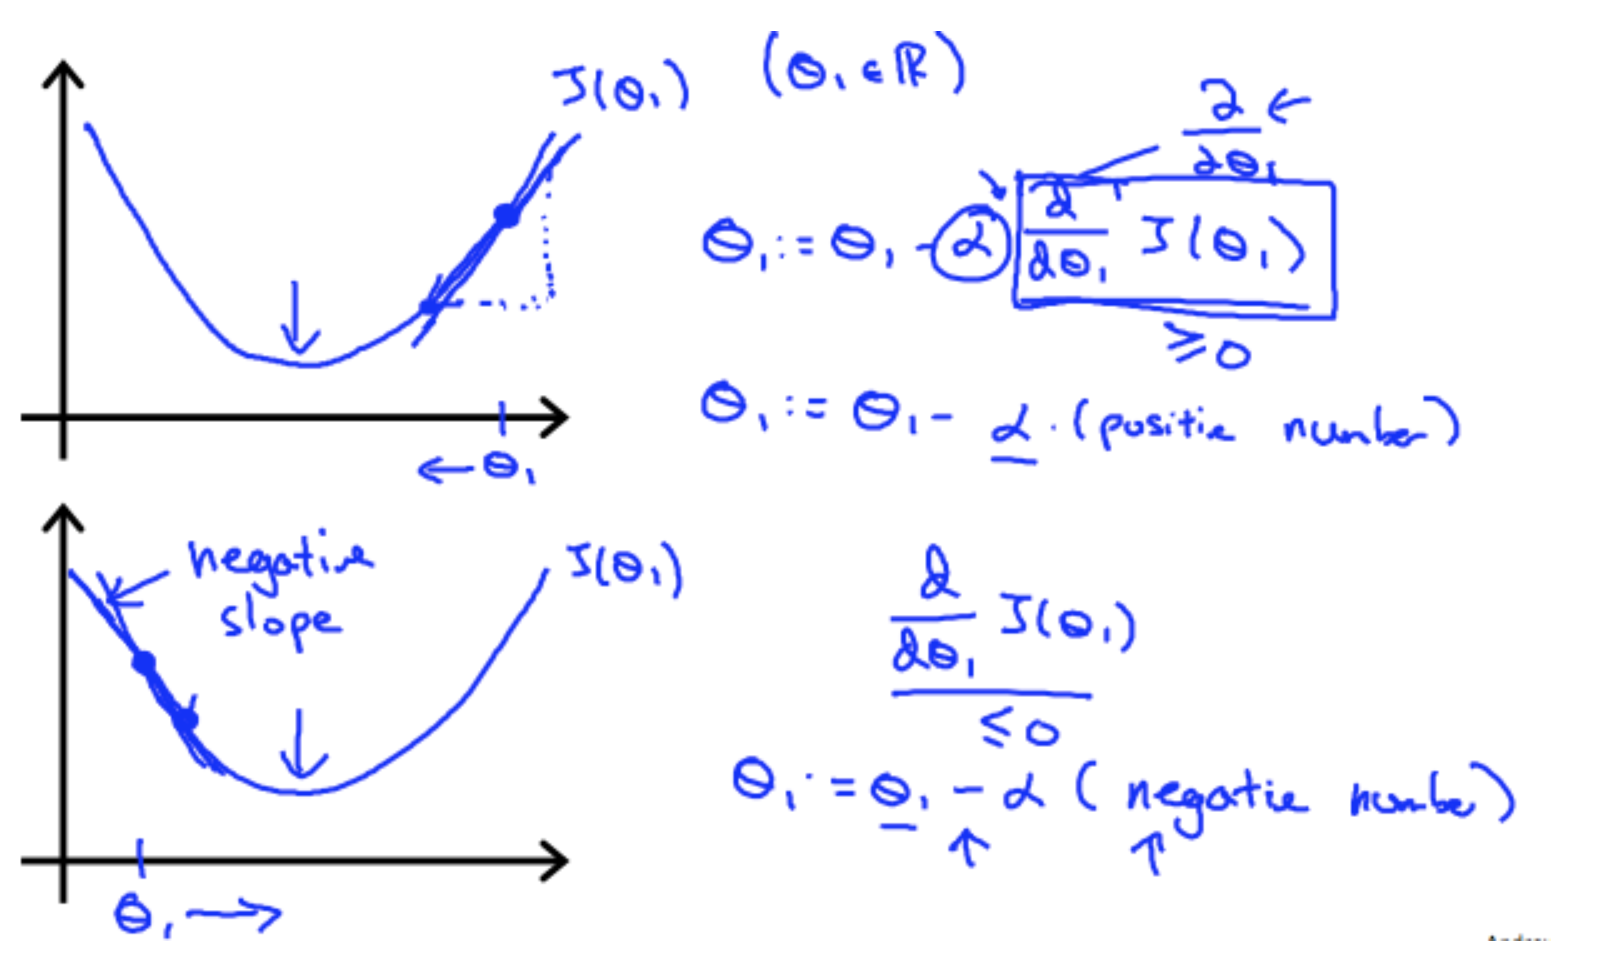

**This picture is provided by Andrew Ng.**

Q: Why $-a*J'(w_{i})$?

A:

When value of $w_{i} < $ minimum point $J'(w_{i})<0 \implies -a*J'(w_{i})>0$

$\therefore w_{i}:=w_{i}-a*J'(w_{i})$ increase the value of $w_{i}$ to equal to minimum error point.

When value of $w_{i} > $ minimum point $J'(w_{i})>0 \implies -a*J'(w_{i})<0$

$\therefore w_{i}:=h_{i}-a*J'(w_{i})$ decrease the value of $w_i$ to equal to minimum error point. (This concept can also be applied with $b$.)

**Keyword**
* Epoch = a single full iteration of the algorithm over the training data. (https://medium.com/@niitwork0921/what-is-epoch-in-machine-learning-1062064d42d6)

##Evaluate the accuracy of the linear regression implementation (R square)

**What is $R^2$?**

$R^2$ indicates how well the data fit the regression model (the goodness of fit). ($R^2$ have the similar purpose to Square Error Function, $J(h)$)

**Note that**
* Large $R^2$ does not guarantee good prediction. It is simply a measure of how well the model explains the variability in the observed data

**This is Square Error Function**
* $J(\vec{w},b)$ =$\frac{1}{2m}\sum_{i=1}^m(y'_i-y_i)^2\in\mathbb{R}$

**This is $R^2$**
* $R^2(\vec{y}_m,\vec{y}'_m)=1-\frac{\Sigma_{i=1}^m(y_i-y'_i)^2}{\Sigma_{i=1}^m(y_i-\overline{y})^2}\in[0,1]\land R^2\in\mathbb{R}$
* $\overline{y}=\frac{1}{m}*\sum_{i=1}^my_i\in\mathbb{R}$

**Why $R^2(\vec{y},\vec{y}')=1-\frac{\Sigma_{i=1}^m(y_i-y'_i)^2}{\Sigma_{i=1}^m(y_i-\overline{y})^2}\in[0,1]$?**

**Why $\Sigma_{i=1}^m(y_i-y'_i)^2$?**
* $\Sigma_{i=1}^m(y_i-y'_i)^2=2m*J(\vec{w},b)=\sum_{i=1}^m(y'_i-y_i)^2$
* $\frac{1}{2m}$ is not useful because $R^2$ have nothing to do with derivative and gradient descent. Moreover $\frac{1}{2m}$ not suit with $R^2\in[0,1]$

**Why $\Sigma_{i=1}^m(y_i-\overline{y})^2$?**
* $\Sigma_{i=1}^m(y_i-\overline{y})^2$ indicates different between accual y-axis value and its average value.

**Why $1-r^2$?**

* Convert minimized error value into accuracy percentage

reference:
* https://stats.stackexchange.com/questions/469654/why-must-the-r-squared-value-of-a-regression-be-less-than-1
* https://towardsdatascience.com/an-ode-to-r-squared-804d8d0ed22c
* https://youtu.be/bMccdk8EdGo

**MSE $J(\vec{w},b)$ or R-Squared $(R^2)$ – Which one to Use?**

* It is recommended to use R-Squared because disadvantage of using MSE than R-squared is that it will be difficult to gauge the performance of the model using MSE as the value of MSE can vary from 0 to any larger number. On the other hand, in the case of R-squared, the value is bounded between 0 and 1. A value of R-squared closer to 1 would mean that the regression model covers most part of the variance of the values of the response variable and can be termed as a good model.

* reference: https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/

#Linear Regression Implementation from Scratch

##Implementation

In [ ]:
def Convert2NumPy(Che):
  if str(type(Che))=="<class 'pandas.core.series.Series'>" or str(type(Che))=="<class 'list'>":
    return np.array(list(Che)).reshape(-1,1)
  elif str(type(Che))=="<class 'pandas.core.frame.DataFrame'>" or str(type(Che))=="<class 'numpy.ndarray'>":
    return Che
  elif str(type(Che))=="<class 'numpy.float64'>" or str(type(Che))=="<class 'numpy.int64'>" or str(type(Che))=="<class 'float'>" or str(type(Che))=="<class 'int'>":
    return np.array([float(Che)]).reshape(-1,1)
  else:
    return Che

def Prediction(X,W,B):
  m=X.shape[0]
  return np.dot(X,W).reshape(-1)+B*np.ones(m)

def MSE(X,Y):
  Sigma=0
  m=0
  for x,y in zip(X,Y):
    Sigma+=(x-y)**2
    m+=1
  return Sigma/m

def R2(X,Y):
  m=X.shape[0]
  meanY=0
  Sigma1=0
  Sigma2=0
  for i in Y:
    meanY+=i
    Sigma1+=1
  meanY=meanY/Sigma1
  Sigma1=0
  for x,y in zip(X,Y):
    Sigma1+=(y-x)**2
    Sigma2+=(y-meanY)**2
  return 1-(Sigma1)/(Sigma2)

def Diff_J(X,Y,W,B):
  m=X.shape[0]
  v1=np.ones((m,1))
  return [
      np.dot((np.dot(X,W)+B*v1-Y).T,X)/m, # dW
      np.dot((np.dot(X,W)+B*v1-Y).T,v1)/m # dB
  ]

def Training(
    W,B,X,Y,tX,tY,
    epoch,  # Learning Time
    a,      # Learning Rate
    ):
  History=[]
  # Batch Gradient Descent
  for i in range(epoch):
    DJ=Diff_J(X,Y,W,B)
    dW=DJ[0].reshape(-1,1)
    dB=DJ[1].reshape(-1)[0]
    W=W-a*dW
    B=B-a*dB

    '''
    # Slowly decrease learning rate.
    W=W-a*pow((1-0.01),i)*dW
    B=B-a*pow((1-0.01),i)*dB
    # reference: https://www.thoughtco.com/exponential-decay-definition-2312215
    '''

    row = pd.DataFrame({
              'epoch No.': [i],
              'MSE_Train': [MSE(Prediction(X,W,B),Y.values.reshape(-1))],
              'MSE_Test': [MSE(Prediction(tX,W,B),tY.values.reshape(-1))],
              })
    History.append(row)
    print('Epoch No.',i)
    print('MSE',row)
    print('** W **\n'+str(W))
    print('** B **\n'+str(B))
  History = pd.concat(History)
  # reference: https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop
  return [W,B,History]


##OOP

In [ ]:
class LinearRegressionn:
    def __init__(
                 self,
                 n
                 ):
        # Define Linear Regression
        self.W=np.ones((n,1))
        self.B=0
        self.TrainingTime=0
        self.History=0

    def _Prediction(self,Input):
        return Prediction(Input,self.W,self.B)
    def _Training(self,X,Y,tX,tY,epoch=1000,a=0.003):
        Start = time.time()
        Fitting=Training(self.W,self.B,X,Y,tX,tY,epoch,a)
        self.W = Fitting[0]
        self.B = Fitting[1]
        self.History = Fitting[2]
        self.TrainingTime=time.time() - Start# reference: https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
        print('Training Time',self.TrainingTime)
    def _Evaluation01_MSE(self,X,Y):
      return MSE(Prediction(X,self.W,self.B).reshape(-1),Y.values.reshape(-1))
    def _Evaluation02_R2(self,X,Y):
        return R2(Prediction(X,self.W,self.B).reshape(-1),Y.values.reshape(-1))

##Evaluating the Model

In [ ]:
MyModel=LinearRegressionn(TrX.shape[1])
MyModel._Training(
    Convert2NumPy(TrX),
    Convert2NumPy(TrY),
    Convert2NumPy(TeX),
    Convert2NumPy(TeY))

Streaming output truncated to the last 5000 lines.
-0.12945049308197493
Epoch No. 762
MSE    epoch No.  MSE_Train  MSE_Test
0        762   3.337245  4.870219
** W **
[[-0.33013087]
 [ 0.04071645]
 [ 0.05158885]
 [ 0.41270595]
 [ 0.3089902 ]
 [ 0.32108037]
 [ 0.43571431]
 [ 0.17796144]
 [-0.0526634 ]
 [ 0.04001903]
 [ 0.06581532]
 [-0.01231015]
 [ 0.0433864 ]
 [ 0.12607624]
 [ 0.98962875]]
** B **
-0.129466874600328
Epoch No. 763
MSE    epoch No.  MSE_Train  MSE_Test
0        763   3.336754  4.869313
** W **
[[-0.32994716]
 [ 0.0406551 ]
 [ 0.05147406]
 [ 0.41239389]
 [ 0.30854959]
 [ 0.32052563]
 [ 0.435646  ]
 [ 0.17791765]
 [-0.05268921]
 [ 0.03975373]
 [ 0.06590473]
 [-0.0123135 ]
 [ 0.04338165]
 [ 0.12605219]
 [ 0.9896225 ]]
** B **
-0.1294832456687248
Epoch No. 764
MSE    epoch No.  MSE_Train  MSE_Test
0        764   3.336265  4.868408
** W **
[[-0.32976385]
 [ 0.04059404]
 [ 0.05135946]
 [ 0.41208222]
 [ 0.30810967]
 [ 0.31997147]
 [ 0.43557774]
 [ 0.17787402]
 [-0.05271484]
 [ 0

In [ ]:
print('Mean Square Error =',MyModel._Evaluation01_MSE(TeX,TeY))
print('R2 =',MyModel._Evaluation02_R2(TeX,TeY))
for i in range(3):
  nn=15
  print('Task No.',i)
  print('** Input **\n'+str(TeX.iloc[nn*i,:]))
  print('Prediction =',MyModel._Prediction(Convert2NumPy(TeX.iloc[nn*i,:]).reshape((1,-1))))
  print('Real Result =',TeY.values[nn*i])

Mean Square Error = 4.697820384917357
R2 = 0.7941111397627575
Task No. 0
** Input **
age           16
Medu           3
Fedu           3
traveltime     1
studytime      3
failures       0
famrel         5
freetime       3
goout          3
Dalc           1
Walc           1
health         5
absences       2
G1            16
G2            18
Name: 108, dtype: int64
Prediction = [18.62195033]
Real Result = [18]
Task No. 1
** Input **
age           15
Medu           3
Fedu           4
traveltime     1
studytime      2
failures       0
famrel         5
freetime       5
goout          1
Dalc           1
Walc           1
health         5
absences       0
G1            14
G2            15
Name: 10, dtype: int64
Prediction = [15.88625929]
Real Result = [15]
Task No. 2
** Input **
age           15
Medu           4
Fedu           4
traveltime     1
studytime      2
failures       0
famrel         4
freetime       3
goout          3
Dalc           1
Walc           1
health         5
absences       2

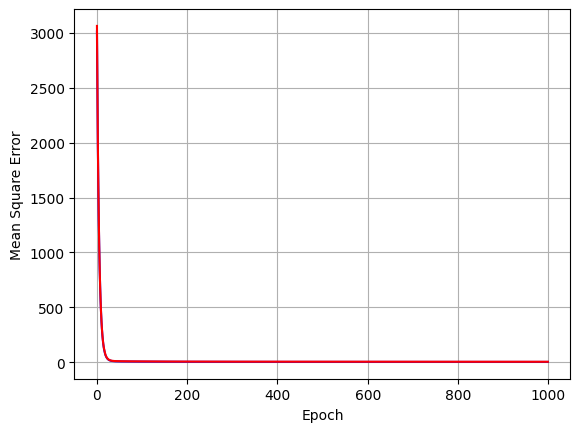

In [ ]:
plt.plot(MyModel.History['epoch No.'],MyModel.History['MSE_Train'],color='blue')
plt.plot(MyModel.History['epoch No.'],MyModel.History['MSE_Test'],color='red')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.grid()
plt.show()

#SKLearn Linear Regression Implementation

In [ ]:
Convert2NumPy(TeX.iloc[10,:]).reshape(1,-1)

array([[18,  4,  4,  2,  3,  0,  4,  2,  2,  2,  2,  5,  0, 13, 13]])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

SK_Line = LinearRegression()
SK_Line.fit(TrX,TrY)

print('Mean Square Error =',mean_squared_error(TeY,SK_Line.predict(TeX)))
print('R2 =',r2_score(TeY,SK_Line.predict(TeX)))
for i in range(3):
  nn=15
  print('Task No.',i)
  print('** Input **\n'+str(TeX.iloc[nn*i,:]))
  print('Prediction =',SK_Line.predict(Convert2NumPy(TeX.iloc[nn*i,:]).reshape(1,-1)).reshape(-1)[0])
  print('Real Result =',TeY.values[nn*i])

Mean Square Error = 4.370192958265348
R2 = 0.808469891679372
Task No. 0
** Input **
age           16
Medu           3
Fedu           3
traveltime     1
studytime      3
failures       0
famrel         5
freetime       3
goout          3
Dalc           1
Walc           1
health         5
absences       2
G1            16
G2            18
Name: 108, dtype: int64
Prediction = 18.343354399434816
Real Result = [18]
Task No. 1
** Input **
age           15
Medu           3
Fedu           4
traveltime     1
studytime      2
failures       0
famrel         5
freetime       5
goout          1
Dalc           1
Walc           1
health         5
absences       0
G1            14
G2            15
Name: 10, dtype: int64
Prediction = 15.655520918830131
Real Result = [15]
Task No. 2
** Input **
age           15
Medu           4
Fedu           4
traveltime     1
studytime      2
failures       0
famrel         4
freetime       3
goout          3
Dalc           1
Walc           1
health         5
absence

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#Linear Regression Visualization

##Ploting the accual and predicted value

In [ ]:
for i in range(len(df.columns)):
  print('No.',i)
  print('Name:',df.columns[i])
  print()

No. 0
Name: age

No. 1
Name: Medu

No. 2
Name: Fedu

No. 3
Name: traveltime

No. 4
Name: studytime

No. 5
Name: failures

No. 6
Name: famrel

No. 7
Name: freetime

No. 8
Name: goout

No. 9
Name: Dalc

No. 10
Name: Walc

No. 11
Name: health

No. 12
Name: absences

No. 13
Name: G1

No. 14
Name: G2

No. 15
Name: G3



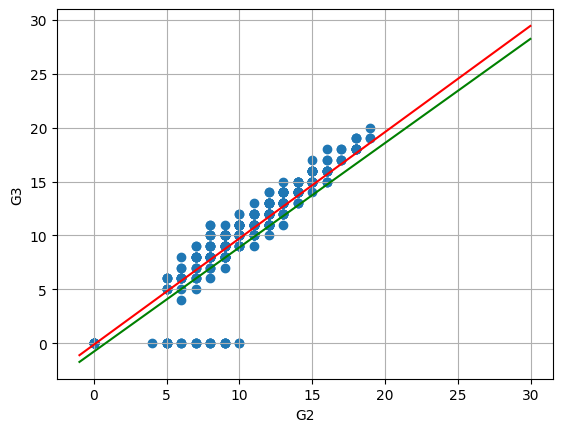

In [ ]:
Col_I=14
plt.scatter(df[df.columns[Col_I]],df[Col_Y])
xpoints = np.arange(-1,30,0.01)
plt.plot(xpoints, xpoints*MyModel.W[Col_I]+MyModel.B,color='red')                   # My Implementation
plt.plot(xpoints, xpoints*SK_Line.coef_.reshape(-1)[Col_I]+SK_Line.intercept_,color='green')
plt.xlabel(df.columns[Col_I])
plt.ylabel(Col_Y[0])
plt.grid() # https://stackoverflow.com/questions/50158333/how-do-i-enforce-a-square-grid-in-matplotlib
plt.show()

**About this graph**

This graph indicates how 2 linear regression models predict the relationship between input and output data, compare to the accual data.

##Ploting bias (x), weight (y) and the Loss function (z)

Text(0.5, 0, 'SquareError')

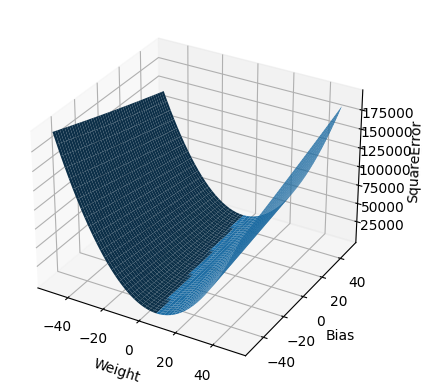

In [ ]:
# import graph library
#import math
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure

def LineR_Evaluation_1f(data,m,c):
    # size of training data = dfM.shape[0]
    # x_i = dfM.iat[i,0]
    # y_i = dfM.iat[i,1]
    sigma =0
    for i in range(data.shape[0]):
      sigma +=pow((data.iat[i,0]*m+c-data.iat[i,1]),2)
    return (1/(2*data.shape[0]))*sigma

N = 50
M = 50

Cost = {
  "X": np.array(list(TrX['G1'])),
  "Y": TrY.to_numpy().reshape(-1)
}

Costs = pd.DataFrame(Cost)
# reference: https://www.w3schools.com/python/pandas/pandas_dataframes.asp

x_values = np.linspace(-50, 50, N)
y_values = np.linspace(-50, 50, M)
X, Y = np.meshgrid(x_values, y_values)
Z = LineR_Evaluation_1f(Costs,X, Y)

# Plotting 3D Data.
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z);

ax.set_xlabel('Weight')
ax.set_ylabel('Bias')
ax.set_zlabel('SquareError')
#ax.view_init(0, 90);
# reference: https://youtu.be/gqoLLGgbeAE

# other related information: https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy

**About this graph**

The lower the areas, means the lower the value of square error (the better the model is).

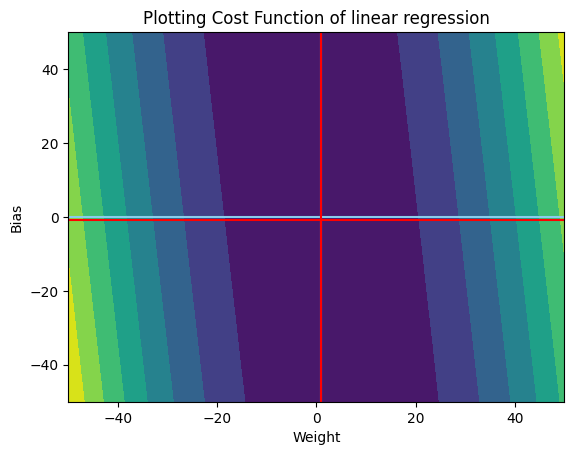

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.contourf(X, Y, Z)
ax.axvline(MyModel.W[-1][0],color='skyblue')
ax.axhline(MyModel.B,color='skyblue')
ax.axvline(SK_Line.coef_[0][-1],color='red')
ax.axhline(SK_Line.intercept_[0],color='red')
ax.set_title('Plotting Cost Function of linear regression')
ax.set_xlabel('Weight')
ax.set_ylabel('Bias')

plt.show()
# reference: https://www.geeksforgeeks.org/contour-plot-using-matplotlib-python/

**About this graph**

The darker the areas of the graph , means the lower the value of loss function (the better the model is). It is noteworthly that the weight and bias usually approach the darker area.